In [128]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
from linearmodels.panel import FamaMacBeth
import warnings
warnings.filterwarnings('ignore')

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from functions.calculate_proximity import calculate_peer_weights
from functions.calculate_monthly_returns import calculate_monthly_returns
from functions.load_datasets import load_datasets
from functions.load_datasets import organize_financial_data_by_year
from functions.load_datasets import sort_columns_chronologically
from functions.create_features import create_features

pd.set_option('future.no_silent_downcasting', True)

In [129]:
base = str(project_root) + "/data/"

config = {
    "df_sales": ("sales.xls", 1),
    "df_capital": ("capital.xls", 1),
    "df_cogs_ratio": ("cost.xls", 1),
    "df_sga_ratio": ("cost.xls", 2),
    "df_roic": ("roic.xls", 1),
    "df_rd_ratio": ("rd_profit.xls", 1),
    "df_opm": ("rd_profit.xls", 2),
    "df_roe": ("roe.xls", 1),
    "df_interest": ("interest_expenses.xls", 1),
}

dfs = {
    name: pd.read_excel(base + file, sheet_name=sheet).rename(columns={"Unnamed: 0": "Company"})
    for name, (file, sheet) in config.items()
}

years = list(range(2025, 2019, -1))
financial_dfs = organize_financial_data_by_year(dfs, years)
df_industry = pd.read_excel(base + "nikkei_industry.xls", sheet_name=1).dropna().rename(columns={"Unnamed: 0": "Company"}).set_index("Company").drop_duplicates()
df_industry = df_industry[~df_industry.index.duplicated(keep='first')].dropna()

In [130]:
rf_df = pd.read_csv(base + "rf.csv", header=None).iloc[:, [0,2]].rename(columns={0: "date", 2: "rf"}).set_index("date")

In [131]:
df_pbr, df_stp, df_mktcap = load_datasets(base)
df_returns = calculate_monthly_returns(df_stp)

In [132]:
def create_monthly_feature_data(financial_dfs, df_pbr_sorted):
    """
    毎月の特徴量データを作成

    ルール:
    - 各年の財務データ（financial_dfs[year]）は、year年6月末から利用可能
    - 例: financial_dfs[2020] は 2020/06 から利用可能
    - 2020/01～2020/05 は financial_dfs[2019] を使用
    - 2020/06～2021/05 は financial_dfs[2020] を使用

    リーク防止:
    - t月のデータにはt月以前に利用可能な財務データのみを使用
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']

    monthly_data = {}

    for month_col in pbr_cols:
        # 月を解析
        year_month = datetime.strptime(month_col, '%Y/%m')
        year = year_month.year
        month = year_month.month

        # 利用可能な財務データの年度を決定
        # 6月以降は当年の財務データ、6月未満は前年の財務データ
        if month >= 6:
            financial_year = year
        else:
            financial_year = year - 1

        # 財務データが存在しない場合はスキップ
        if financial_year not in financial_dfs:
            continue

        # 財務データを取得（インデックスはCompany）
        fin_df = financial_dfs[financial_year].copy()
        fin_df["industry"] = df_industry["日経業種中分類"].reindex(fin_df.index).astype('category')
        fin_df = create_features(fin_df)

        # 空のDataFrameの場合はスキップ
        if len(fin_df) == 0:
            continue

        # PBRデータを取得（この月のPBR）
        # Company列をインデックスに設定してマージできるようにする
        pbr_df = df_pbr_sorted[['Company', month_col]].copy()
        pbr_df = pbr_df.set_index('Company')
        pbr_series = pbr_df[month_col]

        # log_PBRを計算（0や負の値をNaNに変換）
        log_pbr = np.log(pbr_series.replace([0, np.inf, -np.inf], np.nan))

        # インデックス（Company）でマージ
        merged_df = fin_df.copy()
        merged_df['log_pbr'] = log_pbr

        # 欠損値を除外
        #merged_df = merged_df.dropna()

        monthly_data[month_col] = merged_df

    return monthly_data

monthly_feature_data = create_monthly_feature_data(financial_dfs, df_pbr)

print(f"月次特徴量データの作成完了")
print(f"利用可能な月数: {len(monthly_feature_data)}")

# データ構造の確認
available_months = sorted(monthly_feature_data.keys())
if len(available_months) > 0:
    print(f"\n最初の月: {available_months[0]}")
    print(f"最後の月: {available_months[-1]}")
    print(f"\n例 (2021/01): 形状 = {monthly_feature_data.get('2021/01', pd.DataFrame()).shape if '2021/01' in monthly_feature_data else 'なし'}")
    if '2021/01' in monthly_feature_data:
        print(f"  → 使用財務データ: 2020年度 (2020/06から利用可能)")
    print(f"\n例 (2021/06): 形状 = {monthly_feature_data.get('2021/06', pd.DataFrame()).shape if '2021/06' in monthly_feature_data else 'なし'}")
    if '2021/06' in monthly_feature_data:
        print(f"  → 使用財務データ: 2021年度 (2021/06から利用可能)")

月次特徴量データの作成完了
利用可能な月数: 67

最初の月: 2020/06
最後の月: 2025/12

例 (2021/01): 形状 = (4007, 12)
  → 使用財務データ: 2020年度 (2020/06から利用可能)

例 (2021/06): 形状 = (4007, 12)
  → 使用財務データ: 2021年度 (2021/06から利用可能)


In [42]:
# ML戦略: 類似企業加重平均PBRに対する相対PBRを計算
def create_ml_relative_pbr_strategy(monthly_feature_data, df_pbr_sorted, df_returns,
                                      n_quintiles=5, lookback_months=12, top_k=10):
    """
    LightGBMとProximityを使った類似企業ベースの相対PBR戦略

    リーク防止:
    - t月のポートフォリオ形成には、t月以前のデータのみを使用
    - 学習データは過去lookback_months分
    - 財務データは6月末から利用可能なルールに従う

    Parameters:
    -----------
    monthly_feature_data : dict
        月ごとの特徴量データ（財務データ+log_PBR）
    df_pbr_sorted : DataFrame
        PBRデータ（時系列順）
    df_returns : DataFrame
        月次リターンデータ
    n_quintiles : int
        分位数
    lookback_months : int
        学習に使用する過去月数
    top_k : int
        類似企業の数

    Returns:
    --------
    DataFrame
        各分位の月次リターン
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    portfolio_returns = {f'Q{i+1}': [] for i in range(n_quintiles)}
    portfolio_returns['Date'] = []

    # 利用可能な月のリスト
    available_months = sorted([m for m in monthly_feature_data.keys()])

    # 各月について処理（十分な学習データがある月から開始）
    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]

        portfolio_returns['Date'].append(return_month.replace('ret_', ''))

        print(f"\n処理中: {formation_month} → {return_month.replace('ret_', '')}")

        # 現在月のデータが利用可能かチェック
        if formation_month not in monthly_feature_data:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ {formation_month} のデータなし（財務データ利用不可）")
            continue

        current_df = monthly_feature_data[formation_month].copy()

        # 過去lookback_months分のデータを学習データとして収集
        # formation_monthより前の月のみを使用（リーク防止）
        formation_idx = available_months.index(formation_month) if formation_month in available_months else -1

        if formation_idx < 0:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ {formation_month} がavailable_monthsに存在しない")
            continue

        # 過去のデータのみを使用
        past_months = available_months[max(0, formation_idx - lookback_months):formation_idx]

        train_dfs = []
        for past_month in past_months:
            if past_month in monthly_feature_data:
                train_dfs.append(monthly_feature_data[past_month])

        if len(train_dfs) == 0:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ 学習データなし")
            continue

        train_df = pd.concat(train_dfs, axis=0)
        print(f"  学習データ: {len(train_dfs)}ヶ月分、{len(train_df)}サンプル")

        # calculate_peer_weightsで類似度を計算
        try:
            weights_df = calculate_peer_weights(
                train_df=train_df,
                current_features_df=current_df,
                top_k=top_k,
                num_boost_round=100
            )
        except Exception as e:
            print(f"  ⚠ Proximity計算エラー: {e}")
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        if weights_df is None:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ weights_df が None")
            continue

        # 各企業の実際のPBRを取得（formation_monthのPBR）
        pbr_series = df_pbr_sorted.set_index('Company')[formation_month]

        # weights_dfのインデックスと一致する企業のみを対象
        common_companies = weights_df.index.intersection(pbr_series.index)

        if len(common_companies) == 0:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ 共通企業なし")
            continue

        # 類似企業の加重平均PBRを計算
        weights_subset = weights_df.loc[common_companies, common_companies]
        pbr_subset = pbr_series.loc[common_companies]

        peer_avg_pbr = weights_subset @ pbr_subset
        peer_avg_pbr = peer_avg_pbr.fillna(pbr_subset.mean())

        # 相対PBR = 自社PBR / 類似企業平均PBR
        relative_pbr = pbr_subset / peer_avg_pbr

        # リターンデータを取得
        return_series = df_returns.set_index('Company')[return_month]

        # マージ
        temp_df = pd.DataFrame({
            'Company': relative_pbr.index,
            'Relative_PBR': relative_pbr.values,
            'Return': return_series.reindex(relative_pbr.index).values
        })

        temp_df = temp_df.dropna()

        if len(temp_df) < n_quintiles:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            print(f"  ⚠ データ不足: {len(temp_df)}社")
            continue

        # 相対PBRで5分位に分割
        try:
            temp_df['Quintile'] = pd.qcut(temp_df['Relative_PBR'], q=n_quintiles, labels=False, duplicates='drop')
        except Exception as e:
            print(f"  ⚠ 分位分割エラー: {e}")
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        # 各分位の等加重平均リターンを計算
        for q in range(n_quintiles):
            quintile_returns = temp_df[temp_df['Quintile'] == q]['Return']
            avg_return = quintile_returns.mean() if len(quintile_returns) > 0 else np.nan
            portfolio_returns[f'Q{q+1}'].append(avg_return)

        print(f"  ✓ 完了: {len(temp_df)}社、分位別サンプル数 {[len(temp_df[temp_df['Quintile'] == q]) for q in range(n_quintiles)]}")

    result_df = pd.DataFrame(portfolio_returns)
    result_df = result_df.set_index('Date')

    return result_df

# ML戦略を実行
print("=" * 80)
print("ML戦略（類似企業ベース相対PBR）の実行")
print("=" * 80)
print("注: 財務データは決算後3ヶ月（6月末）から利用可能")
print("=" * 80)

quintile_returns_ml = create_ml_relative_pbr_strategy(
    monthly_feature_data=monthly_feature_data,
    df_pbr_sorted=df_pbr,
    df_returns=df_returns,
    n_quintiles=5,
    lookback_months=12,
    top_k=20
)

print("\n" + "=" * 80)
print("ML戦略の構築完了")
print("=" * 80)
print(f"期間: {quintile_returns_ml.index[0]} ～ {quintile_returns_ml.index[-1]}")
print(f"観測数: {len(quintile_returns_ml)}")
print(f"\n最初の10行:")
print(quintile_returns_ml.head(10))

ML戦略（類似企業ベース相対PBR）の実行
注: 財務データは決算後3ヶ月（6月末）から利用可能

処理中: 2020/01 → 2020/02
  ⚠ 2020/01 のデータなし（財務データ利用不可）

処理中: 2020/02 → 2020/03
  ⚠ 2020/02 のデータなし（財務データ利用不可）

処理中: 2020/03 → 2020/04
  ⚠ 2020/03 のデータなし（財務データ利用不可）

処理中: 2020/04 → 2020/05
  ⚠ 2020/04 のデータなし（財務データ利用不可）

処理中: 2020/05 → 2020/06
  ⚠ 2020/05 のデータなし（財務データ利用不可）

処理中: 2020/06 → 2020/07
  ⚠ 学習データなし

処理中: 2020/07 → 2020/08
  学習データ: 1ヶ月分、4007サンプル
corr: 0.9427, rmse: 0.3488
  ✓ 完了: 3218社、分位別サンプル数 [644, 643, 644, 643, 644]

処理中: 2020/08 → 2020/09
  学習データ: 2ヶ月分、8014サンプル
corr: 0.9417, rmse: 0.3768
  ✓ 完了: 3222社、分位別サンプル数 [645, 644, 644, 644, 645]

処理中: 2020/09 → 2020/10
  学習データ: 3ヶ月分、12021サンプル
corr: 0.9400, rmse: 0.3945
  ✓ 完了: 3223社、分位別サンプル数 [645, 644, 645, 644, 645]

処理中: 2020/10 → 2020/11
  学習データ: 4ヶ月分、16028サンプル
corr: 0.9401, rmse: 0.3740
  ✓ 完了: 3233社、分位別サンプル数 [647, 647, 646, 646, 647]

処理中: 2020/11 → 2020/12
  学習データ: 5ヶ月分、20035サンプル
corr: 0.9309, rmse: 0.4029
  ✓ 完了: 3241社、分位別サンプル数 [649, 648, 648, 648, 648]

処理中: 2020/12 → 2021/01
  学

分析対象月: 2025/12
学習データ: 12ヶ月分、48084サンプル
現在月データ: 4007社
corr: 0.9126, rmse: 0.3400
類似企業（上位10社）の業種一致度分析
分析対象企業数: 3985

同業種企業数の分布:
  平均: 8.43 / 10
  中央値: 10.0 / 10
  標準偏差: 2.50
  最小: 0
  最大: 10

同業種割合の平均: 84.4%

同業種企業数の度数分布:
----------------------------------------
   0社:   49 (  1.2%) 
   1社:   62 (  1.6%) 
   2社:   80 (  2.0%) #
   3社:  100 (  2.5%) #
   4社:  142 (  3.6%) #
   5社:  134 (  3.4%) #
   6社:  198 (  5.0%) ##
   7社:  196 (  4.9%) ##
   8社:  267 (  6.7%) ###
   9社:  446 ( 11.2%) #####
  10社: 2311 ( 58.0%) ############################


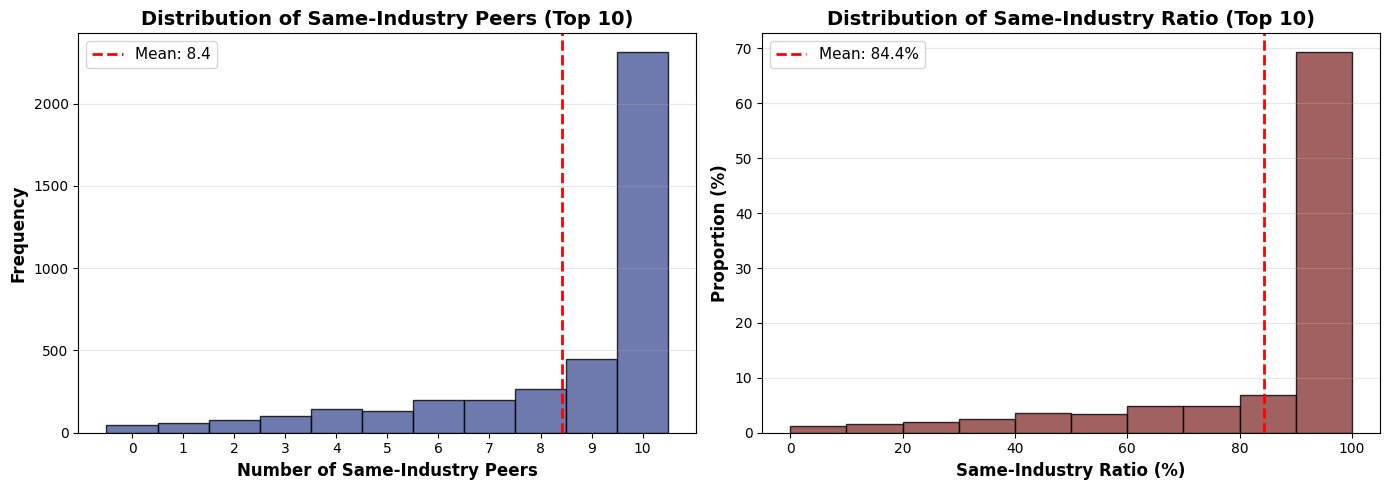

In [43]:
# 類似企業の業種一致度分析
# 最新月のデータを使って、LightGBMが見つける類似企業が同業種かどうかを分析

from functions.analyze_peer_industry import analyze_peer_industry_match

# 最新の利用可能な月を取得
available_months = sorted([m for m in monthly_feature_data.keys()])
latest_month = available_months[-1]

print(f"分析対象月: {latest_month}")
print("=" * 70)

# 最新月の特徴量データを取得
current_df = monthly_feature_data[latest_month].copy()

# 学習データを準備（過去12ヶ月分）
lookback_months = 12
latest_idx = len(available_months) - 1
past_months = available_months[max(0, latest_idx - lookback_months):latest_idx]

train_dfs = [monthly_feature_data[m] for m in past_months if m in monthly_feature_data]
train_df = pd.concat(train_dfs, axis=0)

print(f"学習データ: {len(train_dfs)}ヶ月分、{len(train_df)}サンプル")
print(f"現在月データ: {len(current_df)}社")

# 類似度計算
weights_df = calculate_peer_weights(
    train_df=train_df,
    current_features_df=current_df,
    top_k=10,
    num_boost_round=100
)

# 業種一致度分析（ヒストグラム描画）
result_df = analyze_peer_industry_match(
    weights_df=weights_df,
    df_industry=df_industry,
    top_k=10,
    show_plot=True,
    industry_col="日経業種中分類"
)

In [136]:
quintile_returns_ml.dropna()

,Q1,Q2,Q3,Q4,Q5
Date,,,,,
2020/08,0.070258,0.068913,0.092077,0.101874,0.125235
2020/09,0.041659,0.042896,0.054881,0.062729,0.066039
2020/10,-0.030659,-0.034518,-0.039519,-0.048212,-0.062278
2020/11,0.053938,0.041345,0.055563,0.054647,0.054977
2020/12,0.030929,0.034640,0.022306,0.001307,-0.027142
...,...,...,...,...,...
2025/08,0.062335,0.053695,0.073692,0.045019,0.048210
2025/09,0.025925,0.014563,0.014716,0.005873,-0.018841
2025/10,0.000851,0.003072,-0.006936,-0.005640,-0.022919


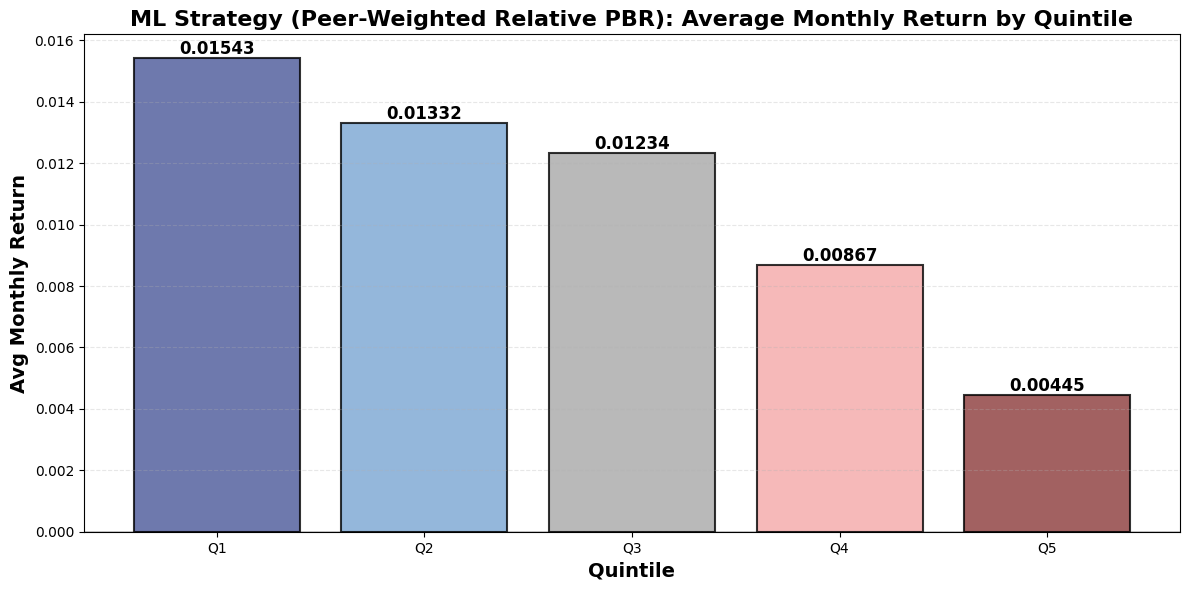


各分位の平均月次リターン（ML戦略）:
Q1: 0.01543 (1.543%)
Q2: 0.01332 (1.332%)
Q3: 0.01234 (1.234%)
Q4: 0.00867 (0.867%)
Q5: 0.00445 (0.445%)


In [134]:
# 図1: ML戦略 - 平均月次リターンのヒストグラム
plt.figure(figsize=(12, 6))

mean_returns_ml = quintile_returns_ml.mean()
colors = ['#4A5899', '#7AA5D2', '#A8A8A8', '#F4A8A8', '#8B3A3A']

bars = plt.bar(mean_returns_ml.index, mean_returns_ml.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Quintile', fontsize=14, fontweight='bold')
plt.ylabel('Avg Monthly Return', fontsize=14, fontweight='bold')
plt.title('ML Strategy (Peer-Weighted Relative PBR): Average Monthly Return by Quintile',
          fontsize=16, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.5f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n各分位の平均月次リターン（ML戦略）:")
for q, ret in mean_returns_ml.items():
    print(f"{q}: {ret:.5f} ({ret*100:.3f}%)")

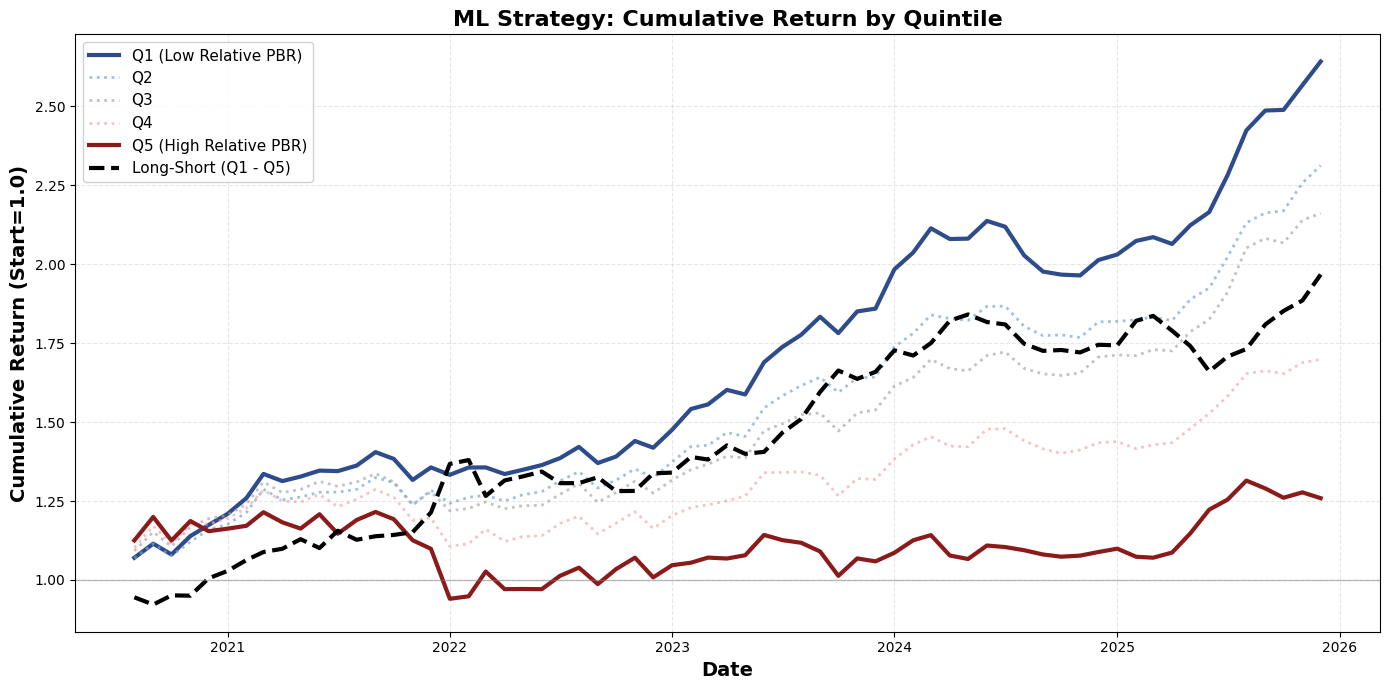


最終累積リターン（ML戦略、開始=1.0）:
Q1: 2.6426 (累積リターン: +164.26%)
Q2: 2.3130 (累積リターン: +131.30%)
Q3: 2.1616 (累積リターン: +116.16%)
Q4: 1.6986 (累積リターン: +69.86%)
Q5: 1.2590 (累積リターン: +25.90%)
Long-Short (Q1-Q5): 1.9677 (累積リターン: +96.77%)


In [45]:
# 図2: ML戦略 - 累積リターンの推移
plt.figure(figsize=(14, 7))

# 累積リターンを計算
cumulative_returns_ml = (1 + quintile_returns_ml).cumprod()

# Long-Short ポートフォリオ
long_short_returns_ml = quintile_returns_ml['Q1'] - quintile_returns_ml['Q5']
cumulative_long_short_ml = (1 + long_short_returns_ml).cumprod()

# 日付インデックス
dates = pd.to_datetime(cumulative_returns_ml.index, format='%Y/%m')

# プロット
plt.plot(dates, cumulative_returns_ml['Q1'], linewidth=3, color='#2E4C8B',
         label='Q1 (Low Relative PBR)', linestyle='-')
plt.plot(dates, cumulative_returns_ml['Q2'], linewidth=2, color='#7AA5D2',
         label='Q2', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_ml['Q3'], linewidth=2, color='#A8A8A8',
         label='Q3', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_ml['Q4'], linewidth=2, color='#F4A8A8',
         label='Q4', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_ml['Q5'], linewidth=3, color='#8B1A1A',
         label='Q5 (High Relative PBR)', linestyle='-')
plt.plot(dates, cumulative_long_short_ml, linewidth=3, color='black',
         label='Long-Short (Q1 - Q5)', linestyle='--')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Return (Start=1.0)', fontsize=14, fontweight='bold')
plt.title('ML Strategy: Cumulative Return by Quintile', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=1, color='gray', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 最終累積リターン
print("\n最終累積リターン（ML戦略、開始=1.0）:")
for col in cumulative_returns_ml.columns:
    final_return = cumulative_returns_ml[col].iloc[-1]
    total_return_pct = (final_return - 1) * 100
    print(f"{col}: {final_return:.4f} (累積リターン: {total_return_pct:+.2f}%)")

final_ls_ml = cumulative_long_short_ml.iloc[-1]
total_ls_pct_ml = (final_ls_ml - 1) * 100
print(f"Long-Short (Q1-Q5): {final_ls_ml:.4f} (累積リターン: {total_ls_pct_ml:+.2f}%)")

In [46]:
# ML戦略のバリュープレミアム統計分析
value_premium_ml = quintile_returns_ml['Q1'] - quintile_returns_ml['Q5']

print("\n" + "=" * 80)
print("ML戦略のバリュープレミアム（Q1 - Q5）の統計分析")
print("=" * 80)
print(f"平均月次プレミアム: {value_premium_ml.mean():.5f} ({value_premium_ml.mean()*100:.3f}%)")
print(f"標準偏差: {value_premium_ml.std():.5f}")
print(f"t値: {value_premium_ml.mean() / (value_premium_ml.std() / np.sqrt(len(value_premium_ml))):.4f}")

# t検定
t_stat_ml, p_value_ml = stats.ttest_1samp(value_premium_ml.dropna(), 0)
print(f"p値: {p_value_ml:.6f}")

if p_value_ml < 0.01:
    sig_ml = '***'
elif p_value_ml < 0.05:
    sig_ml = '**'
elif p_value_ml < 0.1:
    sig_ml = '*'
else:
    sig_ml = ''

print(f"有意性: {sig_ml} ({'有意' if sig_ml else '有意でない'})")
print(f"\n勝率（プレミアムが正の月）: {(value_premium_ml > 0).sum() / len(value_premium_ml) * 100:.2f}%")
print("=" * 80)


ML戦略のバリュープレミアム（Q1 - Q5）の統計分析
平均月次プレミアム: 0.01098 (1.098%)
標準偏差: 0.03233
t値: 2.8605
p値: 0.008018
有意性: *** (有意)

勝率（プレミアムが正の月）: 61.97%


In [51]:
# シャープレシオの計算（リスクフリーレートを考慮）
print("\n" + "=" * 80)
print("シャープレシオの計算（リスクフリーレートを考慮）")
print("=" * 80)

# リスクフリーレート
rf_monthly = rf_df['rf'] / 100

# 各分位のシャープレシオ
sharpe_ratios_ml = {}
for col in quintile_returns_ml.columns:
    # 各月のリターンからリスクフリーレートを引いて超過リターンを計算
    excess_returns = quintile_returns_ml[col].copy()
    for idx in excess_returns.index:
        if idx in rf_monthly.index:
            excess_returns[idx] = excess_returns[idx] - rf_monthly[idx]

    mean_excess = excess_returns.mean()
    std_return = excess_returns.std()
    sharpe_monthly = mean_excess / std_return if std_return > 0 else 0
    sharpe_annual = sharpe_monthly * np.sqrt(12)
    sharpe_ratios_ml[col] = {
        '月次': sharpe_monthly,
        '年率換算': sharpe_annual
    }

# Long-Short戦略（既に差分なのでリスクフリーレートは相殺される）
ls_ml_mean = value_premium_ml.mean()
ls_ml_std = value_premium_ml.std()
ls_ml_sharpe_monthly = ls_ml_mean / ls_ml_std if ls_ml_std > 0 else 0
ls_ml_sharpe_annual = ls_ml_sharpe_monthly * np.sqrt(12)

sharpe_ratios_ml['Long-Short (Q1-Q5)'] = {
    '月次': ls_ml_sharpe_monthly,
    '年率換算': ls_ml_sharpe_annual
}

sharpe_df_ml = pd.DataFrame(sharpe_ratios_ml).T
print("\nシャープレシオ:")
print(sharpe_df_ml.to_string())

print("\n" + "=" * 80)
print("解釈:")
print("-" * 80)
print("- シャープレシオ = (平均リターン - リスクフリーレート) / リターンの標準偏差")
print("- リスク調整後のパフォーマンスを測定")
print("- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる")
print("- 年率換算 = 月次シャープレシオ × sqrt(12)")
print("- Long-Shortはロング・ショート両方からRfを引くため相殺される")
print("=" * 80)


シャープレシオの計算（リスクフリーレートを考慮）

シャープレシオ:
                          月次      年率換算
Q1                  0.530888  1.839050
Q2                  0.471471  1.633225
Q3                  0.396881  1.374835
Q4                  0.246330  0.853311
Q5                  0.083588  0.289557
Long-Short (Q1-Q5)  0.339480  1.175993

解釈:
--------------------------------------------------------------------------------
- シャープレシオ = (平均リターン - リスクフリーレート) / リターンの標準偏差
- リスク調整後のパフォーマンスを測定
- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる
- 年率換算 = 月次シャープレシオ × sqrt(12)
- Long-Shortはロング・ショート両方からRfを引くため相殺される


In [48]:
# ===================================================================
# Fama-French 3ファクターモデルによるアルファ検証
# ===================================================================

print("時価総額データの形状:", df_mktcap.shape)
print("\n時価総額データの最初の数行:")
print(df_mktcap.head())

# 列名のマッピング（P → 2025, P-1 → 2024, ...）
# P, P-1, P-2, ... の形式を YYYY/MM に変換
def map_mktcap_columns(df_mktcap):
    """
    時価総額データの列名を年/月形式に変換
    P → 2025, P-1 → 2024, P-2 → 2023, ...
    """
    new_columns = {'Company': 'Company'}

    for col in df_mktcap.columns:
        if col == 'Company':
            continue

        if col == 'P':
            # P → 2025年（決算月を12月と仮定）
            new_columns[col] = '2025/12'
        elif col.startswith('P-'):
            # P-1 → 2024, P-2 → 2023, ...
            offset = int(col.split('-')[1])
            year = 2025 - offset
            new_columns[col] = f'{year}/12'

    df_renamed = df_mktcap.rename(columns=new_columns)
    return df_renamed

df_mktcap_renamed = map_mktcap_columns(df_mktcap)

print("\n列名マッピング後:")
print(df_mktcap_renamed.columns.tolist()[:10])

時価総額データの形状: (4103, 22)

時価総額データの最初の数行:
          Company             P           P-1           P-2           P-3  \
0     あい　ホールディングス  146023190000  1.481009e+11  1.427736e+11  1.492730e+11   
1  あいちフィナンシャルグループ  221001040000  2.263616e+11  1.937119e+11  1.522892e+11   
2          あおぞら銀行  330730920000  3.341904e+11  3.051995e+11  3.203522e+11   
3          あかつき本社   16859880000  1.713170e+10  1.619341e+10  1.658689e+10   
4       あさかわシステムズ    1316340000  1.316340e+09  1.316340e+09  1.316340e+09   

            P-4           P-5           P-6           P-7           P-8  ...  \
0  1.373930e+11  1.289765e+11  1.249277e+11  1.226369e+11  1.125690e+11  ...   
1  1.426889e+11  1.324761e+11  1.235860e+11  1.259233e+11  1.335867e+11  ...   
2  3.170311e+11  3.068601e+11  2.991799e+11  2.900468e+11  2.719188e+11  ...   
3  1.688957e+10  1.607234e+10  1.525510e+10  1.501295e+10  1.474057e+10  ...   
4  1.316340e+09  1.316340e+09  1.316340e+09  1.316340e+09  1.316340e+09  ...   

           P-11  

In [ ]:
# 時系列順に並び替え
df_mktcap_sorted = sort_columns_chronologically(df_mktcap_renamed)

print("時価総額データを時系列順に並び替え完了")
print(f"列の例: {df_mktcap_sorted.columns.tolist()[1:11]}")

# Carhart 4ファクターの構築
def construct_carhart4_factors(df_pbr_sorted, df_stp_sorted, df_mktcap_sorted, df_returns, rf_df):
    """
    Carhart 4ファクターを構築

    Factors:
    1. Mkt-Rf: 市場超過リターン（時価総額加重市場リターン - リスクフリーレート）
    2. SMB (Small Minus Big): 小型株 - 大型株
    3. HML (High Minus Low): 低PBR株 - 高PBR株（バリュー - グロース）
    4. MOM (Momentum): 過去勝者 - 過去敗者（過去11ヶ月リターンで分類）

    Parameters:
    -----------
    df_pbr_sorted : DataFrame
        PBRデータ
    df_stp_sorted : DataFrame
        株価データ
    df_mktcap_sorted : DataFrame
        時価総額データ
    df_returns : DataFrame
        リターンデータ
    rf_df : DataFrame
        リスクフリーレートデータ（年率%表記、インデックスがdate）

    Returns:
    --------
    DataFrame
        月次ファクターリターン
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    rf_monthly = rf_df['rf'] / 100

    factors = {
        'Date': [],
        'Mkt_Rf': [],
        'SMB': [],
        'HML': [],
        'MOM': [],
        'Rf': []
    }

    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]
        date_str = return_month.replace('ret_', '')

        factors['Date'].append(date_str)

        # リスクフリーレートを取得
        if date_str in rf_monthly.index:
            rf_rate = rf_monthly[date_str]
        else:
            rf_rate = 0.0
        factors['Rf'].append(rf_rate)

        # 時価総額データを取得
        if formation_month not in df_mktcap_sorted.columns:
            available_mktcap_cols = [col for col in df_mktcap_sorted.columns if col != 'Company' and col <= formation_month]
            if len(available_mktcap_cols) == 0:
                factors['Mkt_Rf'].append(np.nan)
                factors['SMB'].append(np.nan)
                factors['HML'].append(np.nan)
                factors['MOM'].append(np.nan)
                continue
            mktcap_month = available_mktcap_cols[-1]
        else:
            mktcap_month = formation_month

        # ===== モメンタムの計算（過去11ヶ月: t-12 から t-2） =====
        current_idx = return_cols.index(return_month)

        if current_idx >= 12:
            past_return_cols = return_cols[current_idx-12:current_idx-1]  # t-12 to t-2
            returns_subset = df_returns.set_index('Company')[past_return_cols]
            past_cumret = (1 + returns_subset).prod(axis=1) - 1

            momentum_df = pd.DataFrame({
                'Company': past_cumret.index,
                'PastReturn': past_cumret.values
            }).set_index('Company')
        else:
            momentum_df = None

        # データを統合
        temp_df = pd.DataFrame({
            'Company': df_pbr_sorted['Company'],
            'PBR': df_pbr_sorted[formation_month],
            'MktCap': df_mktcap_sorted[mktcap_month],
            'Return': df_returns[return_month]
        })

        # モメンタムデータを結合
        if momentum_df is not None:
            temp_df = temp_df.set_index('Company').join(momentum_df, how='left').reset_index()
        else:
            temp_df['PastReturn'] = np.nan

        temp_df = temp_df.dropna()

        if len(temp_df) < 10:
            factors['Mkt_Rf'].append(np.nan)
            factors['SMB'].append(np.nan)
            factors['HML'].append(np.nan)
            factors['MOM'].append(np.nan)
            continue

        # 1. Mkt-Rf: 時価総額加重市場リターン - リスクフリーレート
        total_mktcap = temp_df['MktCap'].sum()
        temp_df['Weight'] = temp_df['MktCap'] / total_mktcap
        mkt_return = (temp_df['Weight'] * temp_df['Return']).sum()
        mkt_rf = mkt_return - rf_rate
        factors['Mkt_Rf'].append(mkt_rf)

        # 2. SMB: 時価総額で2分割
        median_mktcap = temp_df['MktCap'].median()
        small_stocks = temp_df[temp_df['MktCap'] <= median_mktcap]
        big_stocks = temp_df[temp_df['MktCap'] > median_mktcap]

        smb = small_stocks['Return'].mean() - big_stocks['Return'].mean()
        factors['SMB'].append(smb)

        # 3. HML: PBRで3分割（Low 30% vs High 30%）
        pbr_30 = temp_df['PBR'].quantile(0.3)
        pbr_70 = temp_df['PBR'].quantile(0.7)

        low_pbr = temp_df[temp_df['PBR'] <= pbr_30]  # Value
        high_pbr = temp_df[temp_df['PBR'] >= pbr_70]  # Growth

        hml = low_pbr['Return'].mean() - high_pbr['Return'].mean()
        factors['HML'].append(hml)

        # 4. MOM: 過去リターンで3分割（Winners 30% vs Losers 30%）
        if 'PastReturn' in temp_df.columns and temp_df['PastReturn'].notna().sum() > 10:
            mom_30 = temp_df['PastReturn'].quantile(0.3)
            mom_70 = temp_df['PastReturn'].quantile(0.7)

            losers = temp_df[temp_df['PastReturn'] <= mom_30]
            winners = temp_df[temp_df['PastReturn'] >= mom_70]

            mom = winners['Return'].mean() - losers['Return'].mean()
            factors['MOM'].append(mom)
        else:
            factors['MOM'].append(np.nan)

    factors_df = pd.DataFrame(factors).set_index('Date')

    return factors_df

# Carhart 4ファクターを構築
print("=" * 80)
print("Carhart 4ファクターの構築（リスクフリーレートを考慮）")
print("=" * 80)

carhart_factors = construct_carhart4_factors(df_pbr, df_stp, df_mktcap_sorted, df_returns, rf_df)

print(f"\nファクターデータの形状: {carhart_factors.shape}")
print(f"期間: {carhart_factors.index[0]} ～ {carhart_factors.index[-1]}")
print(f"\n最初の10行:")
print(carhart_factors.head(10))
print(f"\n基本統計量:")
print(carhart_factors.describe())

In [53]:
# Carhart 4ファクター回帰分析
import statsmodels.api as sm

print("\n" + "=" * 80)
print("Carhart 4ファクターモデルによる回帰分析（リスクフリーレート考慮）")
print("=" * 80)

# ロングショート戦略のリターンとファクターをマージ
regression_data = pd.DataFrame({
    'LS_Return': value_premium_ml,
    'Mkt_Rf': carhart_factors['Mkt_Rf'],
    'SMB': carhart_factors['SMB'],
    'HML': carhart_factors['HML'],
    'MOM': carhart_factors['MOM'],
    'Rf': carhart_factors['Rf']
})

# 欠損値を除外
regression_data = regression_data.dropna()

print(f"\n回帰分析用データ:")
print(f"  サンプル数: {len(regression_data)}")
print(f"  期間: {regression_data.index[0]} ～ {regression_data.index[-1]}")
print(f"  平均リスクフリーレート（月次）: {regression_data['Rf'].mean()*100:.4f}%")
print(f"  平均リスクフリーレート（年率）: {regression_data['Rf'].mean()*12*100:.4f}%")

if len(regression_data) < 10:
    print("\n⚠ サンプル数が不足しています")
else:
    # 説明変数
    X = regression_data[['Mkt_Rf', 'SMB', 'HML', 'MOM']]
    X = sm.add_constant(X)

    # 被説明変数（Long-Shortはロング・ショート両方からRfを引くため相殺される）
    y = regression_data['LS_Return']

    # OLS回帰
    model = sm.OLS(y, X)
    results = model.fit()

    print("\n" + "-" * 80)
    print("回帰結果:")
    print("-" * 80)
    print(results.summary())

    # アルファの抽出
    alpha = results.params['const']
    alpha_tstat = results.tvalues['const']
    alpha_pvalue = results.pvalues['const']

    print("\n" + "=" * 80)
    print("【アルファの統計的有意性】")
    print("=" * 80)
    print(f"アルファ (月次): {alpha:.6f} ({alpha * 100:.4f}%)")
    print(f"アルファ (年率): {alpha * 12:.6f} ({alpha * 12 * 100:.4f}%)")
    print(f"t値: {alpha_tstat:.4f}")
    print(f"p値: {alpha_pvalue:.6f}")

    if alpha_pvalue < 0.01:
        sig = '***'
        conclusion = "統計的に非常に有意（p < 0.01）"
    elif alpha_pvalue < 0.05:
        sig = '**'
        conclusion = "統計的に有意（p < 0.05）"
    elif alpha_pvalue < 0.1:
        sig = '*'
        conclusion = "統計的にやや有意（p < 0.1）"
    else:
        sig = ''
        conclusion = "統計的に有意でない（p >= 0.1）"

    print(f"有意性: {sig}")
    print(f"\n結論: アルファは{conclusion}")

    if alpha > 0 and alpha_pvalue < 0.05:
        print("→ ML戦略は市場、サイズ、バリュー、モメンタムファクターでは説明できない")
        print("  統計的に有意な超過リターン（アルファ）を生成しています。")
    elif alpha > 0 and alpha_pvalue < 0.1:
        print("→ ML戦略はやや有意な超過リターンを示しています。")
    else:
        print("→ ML戦略の超過リターンは統計的に有意ではありません。")

    print("\n" + "-" * 80)
    print("ファクターローディング:")
    print("-" * 80)
    print(f"市場ファクター (Mkt-Rf):    {results.params['Mkt_Rf']:.4f} (t={results.tvalues['Mkt_Rf']:.2f})")
    print(f"サイズファクター (SMB):     {results.params['SMB']:.4f} (t={results.tvalues['SMB']:.2f})")
    print(f"バリューファクター (HML):   {results.params['HML']:.4f} (t={results.tvalues['HML']:.2f})")
    print(f"モメンタムファクター (MOM): {results.params['MOM']:.4f} (t={results.tvalues['MOM']:.2f})")

    print("\n" + "-" * 80)
    print("モデル適合度:")
    print("-" * 80)
    print(f"R-squared: {results.rsquared:.4f}")
    print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")
    print("=" * 80)

In [105]:
# ===================================================================
# Fama-MacBeth回帰によるMLシグナルの有効性検証
# ===================================================================
# MLで作成した「相対PBR」シグナルが、単純なPBR（バリュー効果）を超えて
# 追加的な予測力を持つかを検証する

import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("Fama-MacBeth回帰によるMLシグナルの有効性検証")
print("=" * 80)

# ===================================================================
# Step 1: 追加データの読み込み
# ===================================================================

# 業種データの読み込み
df_industry = pd.read_excel(base + "nikkei_industry.xls", sheet_name=1).rename(columns={"Unnamed: 0": "Company"})
print(f"\n業種データ: {df_industry.shape}")
print(f"業種数: {df_industry['日経業種中分類'].nunique()}")

# TOPIXデータの読み込み（市場ベータ計算用）
df_topix = pd.read_excel(base + "topix.xls", sheet_name=1)
print(f"TOPIXデータ: {df_topix.shape}")

# ===================================================================
# Step 2: MLシグナル（相対PBR）と類似企業平均PBRを各月で計算・保存
# ===================================================================

def calculate_ml_signals_for_fama_macbeth(monthly_feature_data, df_pbr_sorted, df_returns,
                                          lookback_months=12, top_k=20):
    """
    各月のMLシグナル（相対PBR）を計算し、パネルデータとして保存
    """
    from functions.calculate_proximity import calculate_peer_weights

    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]
    available_months = sorted([m for m in monthly_feature_data.keys()])

    all_data = []

    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]
        date_str = return_month.replace('ret_', '')

        if formation_month not in monthly_feature_data:
            continue

        current_df = monthly_feature_data[formation_month].copy()
        formation_idx = available_months.index(formation_month) if formation_month in available_months else -1

        if formation_idx < 0:
            continue

        past_months = available_months[max(0, formation_idx - lookback_months):formation_idx]
        train_dfs = [monthly_feature_data[m] for m in past_months if m in monthly_feature_data]

        if len(train_dfs) == 0:
            continue

        train_df = pd.concat(train_dfs, axis=0)

        try:
            weights_df = calculate_peer_weights(
                train_df=train_df,
                current_features_df=current_df,
                top_k=top_k,
                num_boost_round=150
            )
        except:
            continue

        if weights_df is None:
            continue

        # PBRデータを取得
        pbr_series = df_pbr_sorted.set_index('Company')[formation_month]
        common_companies = weights_df.index.intersection(pbr_series.index)

        if len(common_companies) == 0:
            continue

        # 類似企業の加重平均PBRを計算
        weights_subset = weights_df.loc[common_companies, common_companies]
        pbr_subset = pbr_series.loc[common_companies]
        # NaN を含まない企業だけ残す
        valid_mask = ~pbr_subset.isna()

        pbr_subset = pbr_subset[valid_mask]
        weights_subset = weights_subset.loc[valid_mask, valid_mask]

        peer_avg_pbr = weights_subset @ pbr_subset

        # 相対PBR = 自社PBR / 類似企業平均PBR
        relative_pbr = pbr_subset / peer_avg_pbr

        # リターンデータ
        return_series = df_returns.set_index('Company')[return_month]

        # データをまとめる
        temp_df = pd.DataFrame({
            'Company': common_companies[valid_mask],
            'Date': date_str,
            'Return': return_series.reindex(common_companies[valid_mask]).values,
            'PBR': pbr_subset.values,
            'log_PBR': np.log(pbr_subset.replace([0, np.inf, -np.inf], np.nan)).values,
            'Peer_Avg_PBR': peer_avg_pbr.values,
            'log_Peer_Avg_PBR': np.log(peer_avg_pbr.replace([0, np.inf, -np.inf], np.nan)).values,
            'Relative_PBR': relative_pbr.values,
            'log_Relative_PBR': np.log(relative_pbr.replace([0, np.inf, -np.inf], np.nan)).values
        })

        #temp_df = temp_df.dropna()

        if len(temp_df) >= 100:
            all_data.append(temp_df)
            print(f"  {date_str}: {len(temp_df)} companies")

    return pd.concat(all_data, ignore_index=True)

print("\n" + "-" * 80)
print("MLシグナル（相対PBR）の計算中...")
print("-" * 80)

panel_ml = calculate_ml_signals_for_fama_macbeth(
    monthly_feature_data, df_pbr, df_returns, lookback_months=12, top_k=10
)

print(f"\nパネルデータ: {panel_ml.shape}")
print(f"期間: {panel_ml['Date'].min()} ～ {panel_ml['Date'].max()}")
print(f"月数: {panel_ml['Date'].nunique()}")

Fama-MacBeth回帰によるMLシグナルの有効性検証

業種データ: (4111, 3)
業種数: 37
TOPIXデータ: (1663, 6)

--------------------------------------------------------------------------------
MLシグナル（相対PBR）の計算中...
--------------------------------------------------------------------------------
corr: 0.9590, rmse: 0.2962
  2020/08: 3240 companies
corr: 0.9548, rmse: 0.3322
  2020/09: 3244 companies
corr: 0.9525, rmse: 0.3540
  2020/10: 3248 companies
corr: 0.9519, rmse: 0.3350
  2020/11: 3258 companies
corr: 0.9435, rmse: 0.3657
  2020/12: 3267 companies
corr: 0.9226, rmse: 0.4156
  2021/01: 3287 companies
corr: 0.9368, rmse: 0.3778
  2021/02: 3286 companies
corr: 0.9434, rmse: 0.3495
  2021/03: 3287 companies
corr: 0.9456, rmse: 0.3532
  2021/04: 3283 companies
corr: 0.9435, rmse: 0.3484
  2021/05: 3284 companies
corr: 0.9446, rmse: 0.3304
  2021/06: 3284 companies
corr: 0.8103, rmse: 0.5942
  2021/07: 3280 companies
corr: 0.8811, rmse: 0.4671
  2021/08: 3280 companies
corr: 0.9070, rmse: 0.4248
  2021/09: 3284 companie

In [ ]:
# ===================================================================
# Step 3: 追加の制御変数を計算
# ===================================================================

from functions.fetch_topix_returns import fetch_topix_returns

# 3-1: 時価総額（Size）を追加
def add_size_variable(panel_df, df_mktcap_sorted):
    """時価総額データを追加"""
    panel_df = panel_df.copy()
    panel_df['log_MktCap'] = np.nan

    for date in panel_df['Date'].unique():
        # 利用可能な最新の時価総額データを取得
        available_cols = [c for c in df_mktcap_sorted.columns if c != 'Company' and c <= date]
        if len(available_cols) == 0:
            continue
        mktcap_col = available_cols[-1]

        mktcap_dict = df_mktcap_sorted.set_index('Company')[mktcap_col].to_dict()
        mask = panel_df['Date'] == date
        panel_df.loc[mask, 'log_MktCap'] = panel_df.loc[mask, 'Company'].map(mktcap_dict).apply(
            lambda x: np.log(x) if pd.notna(x) and x > 0 else np.nan
        )

    return panel_df

# 3-2: モメンタム（過去12ヶ月リターン）を計算
def add_momentum_variable(panel_df, df_returns):
    """12ヶ月モメンタムを追加（t-12からt-1までの累積リターン）"""
    panel_df = panel_df.copy()
    panel_df['Momentum'] = np.nan

    return_cols = [c for c in df_returns.columns if c.startswith('ret_')]

    for date in panel_df['Date'].unique():
        # 現在の月のインデックスを探す
        date_col = f'ret_{date}'
        if date_col not in return_cols:
            continue
        idx = return_cols.index(date_col)

        # 過去12ヶ月（t-12からt-1）のリターンを使用
        if idx < 12:
            continue

        past_cols = return_cols[idx-12:idx]  # t-12 to t-1

        # 各企業の累積リターンを計算
        returns_df = df_returns.set_index('Company')[past_cols]
        cumulative = (1 + returns_df / 100).prod(axis=1) - 1
        cumulative = cumulative * 100  # パーセント表示

        momentum_dict = cumulative.to_dict()
        mask = panel_df['Date'] == date
        panel_df.loc[mask, 'Momentum'] = panel_df.loc[mask, 'Company'].map(momentum_dict)

    return panel_df

# 3-3: 市場ベータを計算（TOPIX ETFを市場リターンとして使用）
def add_beta_variable(panel_df, df_returns, topix_returns, lookback=36):
    """
    過去36ヶ月のデータを使って市場ベータを計算

    Parameters:
    -----------
    panel_df : DataFrame
        パネルデータ
    df_returns : DataFrame
        個別銘柄リターンデータ
    topix_returns : pd.Series
        TOPIX月次リターン系列（fetch_topix_returnsから取得）
    lookback : int
        ベータ計算に使用する過去月数
    """
    panel_df = panel_df.copy()
    panel_df['Beta'] = np.nan

    return_cols = [c for c in df_returns.columns if c.startswith('ret_')]

    for date in panel_df['Date'].unique():
        date_col = f'ret_{date}'
        if date_col not in return_cols:
            continue
        idx = return_cols.index(date_col)

        if idx < lookback:
            continue

        past_cols = return_cols[idx-lookback:idx]
        past_dates = [c.replace('ret_', '') for c in past_cols]

        # TOPIXリターンを取得（YYYY/MM形式でマッチング）
        mkt_ret = []
        for d in past_dates:
            if d in topix_returns.index:
                mkt_ret.append(topix_returns.loc[d].item())
            else:
                mkt_ret.append(np.nan)
        mkt_ret = np.array(mkt_ret)

        if np.isnan(mkt_ret).sum() > lookback // 2:
            continue

        # 各企業のベータを計算
        stock_returns = df_returns.set_index('Company')[past_cols]

        betas = {}
        for company in stock_returns.index:
            y = stock_returns.loc[company].values
            x = mkt_ret

            # 欠損値を除去
            valid = ~(np.isnan(y) | np.isnan(x))
            if valid.sum() < lookback // 2:
                continue

            y_valid, x_valid = y[valid], x[valid]

            # ベータ = Cov(Ri, Rm) / Var(Rm)
            cov = np.cov(y_valid, x_valid)[0, 1]
            var = np.var(x_valid, ddof=1)
            if var > 0:
                betas[company] = cov / var

        mask = panel_df['Date'] == date
        panel_df.loc[mask, 'Beta'] = panel_df.loc[mask, 'Company'].map(betas)

    return panel_df

# 3-4: 業種ダミーを追加
def add_industry_dummies(panel_df, df_industry):
    """業種ダミー変数を追加"""
    panel_df = panel_df.copy()

    industry_dict = df_industry.set_index('Company')['日経業種中分類'].to_dict()
    panel_df['Industry'] = panel_df['Company'].map(industry_dict)

    return panel_df

print("制御変数を追加中...")
print("  - 時価総額（log_MktCap）")
panel_ml = add_size_variable(panel_ml, df_mktcap_sorted)

print("  - モメンタム（12ヶ月累積リターン）")
panel_ml = add_momentum_variable(panel_ml, df_returns)

print("  - 市場ベータ（36ヶ月ローリング、TOPIX ETFを市場リターンとして使用）")
# TOPIXリターンを取得
print("    TOPIXデータをyfinanceから取得中...")
topix_returns = fetch_topix_returns("2018-01-01", "2026-12-31")
print(f"    取得期間: {topix_returns.index[0]} ～ {topix_returns.index[-1]}")
print(f"    観測数: {len(topix_returns)}")

panel_ml = add_beta_variable(panel_ml, df_returns, topix_returns)

print("  - 業種")
panel_ml = add_industry_dummies(panel_ml, df_industry)

# 欠損値を除外
panel_ml_clean = panel_ml.dropna(subset=['Return', 'log_PBR', 'log_Relative_PBR', 'log_MktCap', 'Momentum', 'Beta', 'Industry'])

print(f"\n制御変数追加後のパネルデータ: {panel_ml_clean.shape}")
print(f"期間: {panel_ml_clean['Date'].min()} ～ {panel_ml_clean['Date'].max()}")
print(f"月数: {panel_ml_clean['Date'].nunique()}")
print(f"業種数: {panel_ml_clean['Industry'].nunique()}")

# ベータの分布を確認
print(f"\nベータの統計量:")
print(panel_ml_clean['Beta'].describe())

制御変数を追加中...
  - 時価総額（log_MktCap）
  - モメンタム（12ヶ月累積リターン）
  - 市場ベータ（36ヶ月ローリング、TOPIX ETFを市場リターンとして使用）
    TOPIXデータをyfinanceから取得中...
    取得期間: 2018/02 ～ 2026/01
    観測数: 96
  - 業種

制御変数追加後のパネルデータ: (113706, 13)
期間: 2023/02 ～ 2025/12
月数: 35
業種数: 33

ベータの統計量:
count    113706.000000
mean          0.763618
std           0.656428
min          -6.735518
25%           0.340341
50%           0.667123
75%           1.093508
max          11.747082
Name: Beta, dtype: float64


In [107]:
# ===================================================================
# Fama-MacBeth回帰のヘルパー関数
# ===================================================================

def fama_macbeth_regression(panel_df, y_col, x_cols, use_industry_dummies=False):
    """
    Fama-MacBeth回帰を実行

    Parameters:
    -----------
    panel_df : DataFrame
        パネルデータ（Date, Company, Return, 説明変数）
    y_col : str
        被説明変数の列名
    x_cols : list
        説明変数の列名リスト
    use_industry_dummies : bool
        業種ダミーを使用するか（制御変数として使用、係数は主要変数のみ追跡）

    Returns:
    --------
    dict : 回帰結果
    """
    # 主要変数の係数のみ追跡（業種ダミーは制御変数として使うが係数は追跡しない）
    monthly_coefs = {col: [] for col in ['const'] + x_cols}

    dates = sorted(panel_df['Date'].unique())
    valid_dates = []

    for date in dates:
        month_data = panel_df[panel_df['Date'] == date].copy()

        if len(month_data) < 50:  # 最低サンプル数
            continue

        # 説明変数を準備
        X = month_data[x_cols].copy()

        # 業種ダミーを追加（制御変数として）
        if use_industry_dummies:
            # 欠損値を除外してからダミー変数を作成
            valid_industry = month_data['Industry'].notna()
            if valid_industry.sum() < 50:
                continue

            industry_dummies = pd.get_dummies(month_data['Industry'], prefix='Ind', drop_first=True).astype(int)
            X = pd.concat([X.reset_index(drop=True), industry_dummies.reset_index(drop=True)], axis=1)
            X.index = month_data.index

        X = sm.add_constant(X)
        y = month_data[y_col]

        # 欠損値を除外
        valid_idx = X.notna().all(axis=1) & y.notna()
        X = X[valid_idx]
        y = y[valid_idx]

        if len(y) < 50:
            continue

        try:
            model = sm.OLS(y, X).fit()

            # 主要変数の係数のみ保存
            for col in ['const'] + x_cols:
                if col in model.params.index:
                    monthly_coefs[col].append(model.params[col])
                else:
                    monthly_coefs[col].append(np.nan)

            valid_dates.append(date)
        except Exception as e:
            continue

    # Fama-MacBeth統計量を計算
    results = {}
    for col in monthly_coefs.keys():
        coefs = pd.Series(monthly_coefs[col]).dropna()
        if len(coefs) > 0:
            mean = coefs.mean()
            std = coefs.std(ddof=1)
            n = len(coefs)
            t_stat = mean / (std / np.sqrt(n)) if std > 0 else np.nan
            p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-1)) if not np.isnan(t_stat) else np.nan

            results[col] = {
                'mean': mean,
                'std': std,
                't_stat': t_stat,
                'p_value': p_value,
                'n_months': n
            }

    return results, valid_dates

def print_fama_macbeth_results(results, title):
    """Fama-MacBeth結果を表示"""
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)

    if not results:
        print("結果がありません")
        return

    print(f"\n{'変数':<25} {'平均':<12} {'Std':<12} {'t値':<10} {'p値':<12} {'有意性'}")
    print("-" * 80)

    for var, stats_dict in results.items():
        mean = stats_dict['mean']
        std = stats_dict['std']
        t = stats_dict['t_stat']
        p = stats_dict['p_value']

        if pd.isna(p):
            sig = ''
        elif p < 0.01:
            sig = '***'
        elif p < 0.05:
            sig = '**'
        elif p < 0.1:
            sig = '*'
        else:
            sig = ''

        print(f"{var:<25} {mean:>10.4f}   {std:>10.4f}   {t:>8.3f}   {p:>10.6f}   {sig}")

    print("-" * 80)
    if 'const' in results:
        print(f"観測月数: {results['const']['n_months']}")

print("Fama-MacBeth回帰のヘルパー関数を定義しました")

Fama-MacBeth回帰のヘルパー関数を定義しました


In [108]:
# ===================================================================
# アプローチ1: 直交化（Orthogonalization）【推奨】
# ===================================================================
# MLシグナル（相対PBR）からPBRの影響を除去した純粋なシグナル成分を抽出

print("=" * 80)
print("アプローチ1: 直交化（Orthogonalization）")
print("=" * 80)
print("Signal_i = γ0 + γ1*PBR_i + ε_i")
print("残差ε_iを「MLの純粋な付加価値」として使用")
print("=" * 80)

# 各月で直交化を実行
panel_ml_clean['ML_Signal_Orthogonal'] = np.nan

for date in panel_ml_clean['Date'].unique():
    mask = panel_ml_clean['Date'] == date
    month_data = panel_ml_clean[mask]

    if len(month_data) < 50:
        continue

    # Signal（log相対PBR）をlog_PBRに回帰
    X = sm.add_constant(month_data['log_PBR'])
    y = month_data['log_Relative_PBR']

    valid_idx = X.notna().all(axis=1) & y.notna()
    X_valid = X[valid_idx]
    y_valid = y[valid_idx]

    if len(y_valid) < 50:
        continue

    try:
        model = sm.OLS(y_valid, X_valid).fit()
        residuals = model.resid

        # 残差を元のデータに戻す
        panel_ml_clean.loc[valid_idx[valid_idx].index, 'ML_Signal_Orthogonal'] = residuals.values
    except:
        continue

# 欠損値を除外
panel_ortho = panel_ml_clean.dropna(subset=['ML_Signal_Orthogonal'])
print(f"\n直交化後のデータ: {len(panel_ortho)} observations")

# 直交化シグナルとPBRの相関を確認（0に近いはず）
corr = panel_ortho['ML_Signal_Orthogonal'].corr(panel_ortho['log_PBR'])
print(f"直交化シグナルとlog_PBRの相関: {corr:.6f} (0に近いはず)")

results_1a, _ = fama_macbeth_regression(
    panel_ortho, 'Return',
    ['ML_Signal_Orthogonal', 'log_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=False
)
print_fama_macbeth_results(results_1a, "Model 1a: 基本モデル")

results_1b, _ = fama_macbeth_regression(
    panel_ortho, 'Return',
    ['ML_Signal_Orthogonal', 'log_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=True
)
print_fama_macbeth_results(results_1b, "Model 1b: 業種ダミー付き")

# 結果の解釈
print("\n" + "=" * 80)
print("【アプローチ1の結論】")
print("=" * 80)
ml_sig = results_1b.get('ML_Signal_Orthogonal', {})
if ml_sig:
    t_val = ml_sig['t_stat']
    p_val = ml_sig['p_value']
    mean_coef = ml_sig['mean']

    if p_val < 0.05:
        print(f"✓ 直交化MLシグナルは統計的に有意（t={t_val:.3f}, p={p_val:.4f}）")
        print(f"  → MLによる類似企業選定は、単純なPBRを超えた付加価値を持つ")
        if mean_coef < 0:
            print(f"  → シグナルが低い（=類似企業より相対的に割安）ほどリターンが高い")
    else:
        print(f"✗ 直交化MLシグナルは統計的に有意でない（t={t_val:.3f}, p={p_val:.4f}）")
        print(f"  → MLの付加価値は確認できない")
print("=" * 80)

アプローチ1: 直交化（Orthogonalization）
Signal_i = γ0 + γ1*PBR_i + ε_i
残差ε_iを「MLの純粋な付加価値」として使用

直交化後のデータ: 113706 observations
直交化シグナルとlog_PBRの相関: -0.000000 (0に近いはず)

Model 1a: 基本モデル

変数                        平均           Std          t値         p値           有意性
--------------------------------------------------------------------------------
const                        -0.0508       0.0973     -3.091     0.003969   ***
ML_Signal_Orthogonal         -0.0027       0.0061     -2.645     0.012284   **
log_PBR                      -0.0058       0.0104     -3.275     0.002433   ***
log_MktCap                    0.0027       0.0038      4.104     0.000240   ***
Momentum                      0.0063       0.0232      1.604     0.117899   
Beta                          0.0010       0.0131      0.451     0.654613   
--------------------------------------------------------------------------------
観測月数: 35

Model 1b: 業種ダミー付き

変数                        平均           Std          t値         p値           有意性
--

In [109]:
# ===================================================================
# アプローチ2: モデルの比較（Horse Race）
# ===================================================================
# Model A: リターン ~ PBR + 制御変数
# Model B: リターン ~ 相対PBR（MLシグナル）+ 制御変数
# t値や説明力を比較し、どちらがリターンをより良く説明するかを検証

print("\n" + "=" * 80)
print("アプローチ2: モデルの比較（Horse Race）")
print("=" * 80)
print("Model A: Return ~ log_PBR + Controls")
print("Model B: Return ~ log_Relative_PBR + Controls")
print("多重共線性を回避するため、2つのモデルを別々に推定し比較")
print("=" * 80)

# Model A: log_PBRを使用
print("\n" + "-" * 80)
print("Model A: 単純なPBRモデル")
print("-" * 80)

results_A, _ = fama_macbeth_regression(
    panel_ml_clean, 'Return',
    ['log_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=True
)
print_fama_macbeth_results(results_A, "Model A: Return ~ log_PBR + Controls + Industry")

# Model B: log_Relative_PBRを使用
print("\n" + "-" * 80)
print("Model B: MLシグナル（相対PBR）モデル")
print("-" * 80)

results_B, _ = fama_macbeth_regression(
    panel_ml_clean, 'Return',
    ['log_Relative_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=True
)
print_fama_macbeth_results(results_B, "Model B: Return ~ log_Relative_PBR + Controls + Industry")

# 比較表
print("\n" + "=" * 80)
print("【アプローチ2の比較結果】")
print("=" * 80)

pbr_A = results_A.get('log_PBR', {})
pbr_B = results_B.get('log_Relative_PBR', {})

print(f"\n{'指標':<25} {'Model A (PBR)':<20} {'Model B (Relative PBR)':<20}")
print("-" * 65)
print(f"{'係数の平均':<25} {pbr_A.get('mean', np.nan):>18.4f}   {pbr_B.get('mean', np.nan):>18.4f}")
print(f"{'t値':<25} {pbr_A.get('t_stat', np.nan):>18.3f}   {pbr_B.get('t_stat', np.nan):>18.3f}")
print(f"{'p値':<25} {pbr_A.get('p_value', np.nan):>18.6f}   {pbr_B.get('p_value', np.nan):>18.6f}")

# 結論
print("\n" + "-" * 80)
t_A = abs(pbr_A.get('t_stat', 0))
t_B = abs(pbr_B.get('t_stat', 0))

if t_B > t_A:
    improvement = (t_B - t_A) / t_A * 100 if t_A > 0 else np.inf
    print(f"✓ Model B（MLシグナル）のt値がModel Aより高い")
    print(f"  t値の改善: {t_A:.3f} → {t_B:.3f} (+{improvement:.1f}%)")
    print(f"  → MLで補正した相対PBRの方が、リターンの説明力が高い")
else:
    print(f"✗ Model A（単純PBR）のt値がModel Bより高い")
    print(f"  → 単純なPBRの方が説明力が高く、MLの付加価値は限定的")
print("=" * 80)


アプローチ2: モデルの比較（Horse Race）
Model A: Return ~ log_PBR + Controls
Model B: Return ~ log_Relative_PBR + Controls
多重共線性を回避するため、2つのモデルを別々に推定し比較

--------------------------------------------------------------------------------
Model A: 単純なPBRモデル
--------------------------------------------------------------------------------

Model A: Return ~ log_PBR + Controls + Industry

変数                        平均           Std          t値         p値           有意性
--------------------------------------------------------------------------------
const                        -0.0588       0.0902     -3.857     0.000486   ***
log_PBR                      -0.0058       0.0098     -3.535     0.001199   ***
log_MktCap                    0.0028       0.0037      4.484     0.000079   ***
Momentum                      0.0052       0.0229      1.354     0.184731   
Beta                          0.0006       0.0112      0.341     0.735391   
-------------------------------------------------------------------------

In [110]:
# ===================================================================
# アプローチ3: 対数変換による分解
# ===================================================================
# ln(相対PBR) = ln(PBR) - ln(類似企業平均PBR)
# → Return ~ β1*ln(PBR) + β2*ln(Peer_Avg_PBR) + Controls
#
# 仮説: 相対的な割安さが効くなら、
# - β1 < 0 (自社PBRが低いほど良い)
# - β2 > 0 (類似企業PBRが高い = 自社が相対的に割安なほど良い)

print("\n" + "=" * 80)
print("アプローチ3: 対数変換による分解")
print("=" * 80)
print("Return ~ β1*ln(PBR) + β2*ln(Peer_Avg_PBR) + Controls")
print("")
print("仮説（相対的割安さが効く場合）:")
print("  - β1 < 0: 自社PBRが低いほどリターンが高い（絶対的バリュー効果）")
print("  - β2 > 0: 類似企業PBRが高いほどリターンが高い（相対的割安効果）")
print("=" * 80)

# Model 3: ln(PBR)とln(Peer_Avg_PBR)を両方投入
print("\n" + "-" * 80)
print("Model 3a: 分解モデル（業種ダミーなし）")
print("-" * 80)

results_3a, _ = fama_macbeth_regression(
    panel_ml_clean, 'Return',
    ['log_PBR', 'log_Peer_Avg_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=False
)
print_fama_macbeth_results(results_3a, "Model 3a: Return ~ log_PBR + log_Peer_Avg_PBR + Controls")

# 業種ダミー付き
print("\n" + "-" * 80)
print("Model 3b: 分解モデル（業種ダミー付き）")
print("-" * 80)

results_3b, _ = fama_macbeth_regression(
    panel_ml_clean, 'Return',
    ['log_PBR', 'log_Peer_Avg_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=True
)
print_fama_macbeth_results(results_3b, "Model 3b: Return ~ log_PBR + log_Peer_Avg_PBR + Controls + Industry")

# 結果の解釈
print("\n" + "=" * 80)
print("【アプローチ3の結論】")
print("=" * 80)

beta1 = results_3b.get('log_PBR', {})
beta2 = results_3b.get('log_Peer_Avg_PBR', {})

print(f"\n自社PBR (β1):")
print(f"  係数: {beta1.get('mean', np.nan):.4f}, t値: {beta1.get('t_stat', np.nan):.3f}, p値: {beta1.get('p_value', np.nan):.4f}")

print(f"\n類似企業平均PBR (β2):")
print(f"  係数: {beta2.get('mean', np.nan):.4f}, t値: {beta2.get('t_stat', np.nan):.3f}, p値: {beta2.get('p_value', np.nan):.4f}")

# 判定
print("\n" + "-" * 80)
b1_mean = beta1.get('mean', 0)
b2_mean = beta2.get('mean', 0)
b1_sig = beta1.get('p_value', 1) < 0.05
b2_sig = beta2.get('p_value', 1) < 0.05

if b1_mean < 0 and b2_mean > 0 and b2_sig:
    print("✓ 仮説支持: 相対的な割安さ（類似企業より低いPBR）がリターンに寄与")
    print(f"  - 自社PBRが低い → リターン↑ (β1={b1_mean:.4f})")
    print(f"  - 類似企業PBRが高い（=自社が相対的に割安）→ リターン↑ (β2={b2_mean:.4f})")
elif b1_mean < 0 and b1_sig and not b2_sig:
    print("△ 部分的支持: 絶対的バリュー効果は確認されるが、相対的効果は弱い")
    print(f"  - 自社PBRが低い → リターン↑ (β1={b1_mean:.4f}, 有意)")
    print(f"  - 類似企業PBRの効果は有意でない (β2={b2_mean:.4f})")
else:
    print("✗ 仮説不支持または複雑な結果")
    print(f"  β1={b1_mean:.4f} ({'有意' if b1_sig else '有意でない'})")
    print(f"  β2={b2_mean:.4f} ({'有意' if b2_sig else '有意でない'})")
print("=" * 80)


アプローチ3: 対数変換による分解
Return ~ β1*ln(PBR) + β2*ln(Peer_Avg_PBR) + Controls

仮説（相対的割安さが効く場合）:
  - β1 < 0: 自社PBRが低いほどリターンが高い（絶対的バリュー効果）
  - β2 > 0: 類似企業PBRが高いほどリターンが高い（相対的割安効果）

--------------------------------------------------------------------------------
Model 3a: 分解モデル（業種ダミーなし）
--------------------------------------------------------------------------------

Model 3a: Return ~ log_PBR + log_Peer_Avg_PBR + Controls

変数                        平均           Std          t値         p値           有意性
--------------------------------------------------------------------------------
const                        -0.0510       0.0973     -3.098     0.003891   ***
log_PBR                      -0.0073       0.0106     -4.100     0.000243   ***
log_Peer_Avg_PBR              0.0027       0.0061      2.645     0.012284   **
log_MktCap                    0.0027       0.0038      4.104     0.000240   ***
Momentum                      0.0063       0.0232      1.604     0.117899   
Beta                    

In [111]:
# ===================================================================
# 総合サマリー: 3つのアプローチの比較
# ===================================================================

print("\n" + "=" * 80)
print("=" * 80)
print("総合サマリー: MLシグナル（相対PBR）の有効性検証")
print("=" * 80)
print("=" * 80)

# 各アプローチの主要結果をまとめる
summary_data = []

# アプローチ1: 直交化
ortho_result = results_1b.get('ML_Signal_Orthogonal', {})
summary_data.append({
    'アプローチ': '1. 直交化',
    'シグナル': 'ML_Signal_Orthogonal',
    '係数': ortho_result.get('mean', np.nan),
    't値': ortho_result.get('t_stat', np.nan),
    'p値': ortho_result.get('p_value', np.nan),
    '有意': '***' if ortho_result.get('p_value', 1) < 0.01 else ('**' if ortho_result.get('p_value', 1) < 0.05 else ('*' if ortho_result.get('p_value', 1) < 0.1 else ''))
})

# アプローチ2: Horse Race (Model A - PBR)
pbr_result = results_A.get('log_PBR', {})
summary_data.append({
    'アプローチ': '2a. Horse Race (PBR)',
    'シグナル': 'log_PBR',
    '係数': pbr_result.get('mean', np.nan),
    't値': pbr_result.get('t_stat', np.nan),
    'p値': pbr_result.get('p_value', np.nan),
    '有意': '***' if pbr_result.get('p_value', 1) < 0.01 else ('**' if pbr_result.get('p_value', 1) < 0.05 else ('*' if pbr_result.get('p_value', 1) < 0.1 else ''))
})

# アプローチ2: Horse Race (Model B - Relative PBR)
rel_pbr_result = results_B.get('log_Relative_PBR', {})
summary_data.append({
    'アプローチ': '2b. Horse Race (Relative)',
    'シグナル': 'log_Relative_PBR',
    '係数': rel_pbr_result.get('mean', np.nan),
    't値': rel_pbr_result.get('t_stat', np.nan),
    'p値': rel_pbr_result.get('p_value', np.nan),
    '有意': '***' if rel_pbr_result.get('p_value', 1) < 0.01 else ('**' if rel_pbr_result.get('p_value', 1) < 0.05 else ('*' if rel_pbr_result.get('p_value', 1) < 0.1 else ''))
})

# アプローチ3: 分解 (log_PBR)
decomp_pbr = results_3b.get('log_PBR', {})
summary_data.append({
    'アプローチ': '3a. 分解 (自社PBR)',
    'シグナル': 'log_PBR',
    '係数': decomp_pbr.get('mean', np.nan),
    't値': decomp_pbr.get('t_stat', np.nan),
    'p値': decomp_pbr.get('p_value', np.nan),
    '有意': '***' if decomp_pbr.get('p_value', 1) < 0.01 else ('**' if decomp_pbr.get('p_value', 1) < 0.05 else ('*' if decomp_pbr.get('p_value', 1) < 0.1 else ''))
})

# アプローチ3: 分解 (log_Peer_Avg_PBR)
decomp_peer = results_3b.get('log_Peer_Avg_PBR', {})
summary_data.append({
    'アプローチ': '3b. 分解 (類似企業PBR)',
    'シグナル': 'log_Peer_Avg_PBR',
    '係数': decomp_peer.get('mean', np.nan),
    't値': decomp_peer.get('t_stat', np.nan),
    'p値': decomp_peer.get('p_value', np.nan),
    '有意': '***' if decomp_peer.get('p_value', 1) < 0.01 else ('**' if decomp_peer.get('p_value', 1) < 0.05 else ('*' if decomp_peer.get('p_value', 1) < 0.1 else ''))
})

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# 総合判定
print("\n" + "=" * 80)
print("【総合判定】")
print("=" * 80)

# 判定ロジック
ortho_sig = ortho_result.get('p_value', 1) < 0.05
horse_race_better = abs(rel_pbr_result.get('t_stat', 0)) > abs(pbr_result.get('t_stat', 0))
peer_effect_sig = decomp_peer.get('p_value', 1) < 0.05 and decomp_peer.get('mean', 0) > 0

evidence_count = sum([ortho_sig, horse_race_better, peer_effect_sig])

if evidence_count >= 2:
    print("✓✓✓ 強い証拠: MLシグナルは単純なPBRを超えた付加価値を持つ")
    print(f"   - 直交化シグナル: {'有意' if ortho_sig else '有意でない'}")
    print(f"   - Horse Race: {'相対PBRが優位' if horse_race_better else '単純PBRが優位'}")
    print(f"   - 類似企業PBR効果: {'有意（正）' if peer_effect_sig else '有意でないまたは負'}")
elif evidence_count == 1:
    print("△△ 部分的証拠: MLシグナルにある程度の付加価値が見られる")
else:
    print("✗✗ 証拠不十分: MLシグナルの付加価値は確認できない")
    print("   単純なPBRによるバリュー投資で十分かもしれない")

print("\n" + "-" * 80)
print("注: すべての結果は業種ダミー、サイズ、モメンタム、ベータをコントロール")
print("=" * 80)


総合サマリー: MLシグナル（相対PBR）の有効性検証

                    アプローチ                 シグナル        係数        t値       p値  有意
                   1. 直交化 ML_Signal_Orthogonal -0.002935 -2.203032 0.034469  **
     2a. Horse Race (PBR)              log_PBR -0.005838 -3.535148 0.001199 ***
2b. Horse Race (Relative)     log_Relative_PBR -0.006267 -4.554715 0.000064 ***
           3a. 分解 (自社PBR)              log_PBR -0.007228 -4.333074 0.000123 ***
         3b. 分解 (類似企業PBR)     log_Peer_Avg_PBR  0.002935  2.203032 0.034469  **

【総合判定】
✓✓✓ 強い証拠: MLシグナルは単純なPBRを超えた付加価値を持つ
   - 直交化シグナル: 有意
   - Horse Race: 相対PBRが優位
   - 類似企業PBR効果: 有意（正）

--------------------------------------------------------------------------------
注: すべての結果は業種ダミー、サイズ、モメンタム、ベータをコントロール
